Import

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import time

데이터 전처리

In [ ]:
(x_train, y_train), (x_test, y_test) =tf.keras.datasets.cifar10.load_data()

train_filter = (y_train == 0) | (y_train == 1)
test_filter = (y_test == 0) | (y_test == 1)

x_train, y_train = x_train[train_filter.flatten()], y_train[train_filter.flatten()]
x_test, y_test = x_test[test_filter.flatten()], y_test[test_filter.flatten()]

y_train = (y_train == 1).astype(float)
y_test = (y_test == 1).astype(float)

x_train = tf.image.resize(x_train, (96, 96))
x_test = tf.image.resize(x_test, (96, 96))

x_train = tf.keras.applications.mobilenet_v2.preprocess_input(x_train)
x_test = tf.keras.applications.mobilenet_v2.preprocess_input(x_test)

print(f"Train data: {len(x_train)}, Test data: {len(x_test)}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 609s 4us/step
Train data: 10000, Test data: 2000


모델 구성 컴파일

In [ ]:
from prompt_toolkit.styles import base
def create_simple_cnn():
  model = models.Sequential([
      layers.Conv2D(32,(3,3),activation='relu',input_shape=(96,96,3)),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64,(3,3),activation='relu'),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64,(3,3),activation='relu'),
      layers.Flatten(),
      layers.Dense(64,activation='relu'),
      layers.Dense(1,activation='sigmoid')
  ])
  return model

def create_transfer_model(): # Unindented to be a top-level function
  base_model = tf.keras.applications.MobileNetV2(
      input_shape=(96,96,3),
      include_top=False,
      weights='imagenet'
  )
  base_model.trainable = False

  model = models.Sequential([
      base_model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(32,activation='relu'),
      layers.Dense(1,activation='sigmoid') # Fixed typo: 'layes' to 'layers'
  ])
  return model

simple_model = create_simple_cnn()
simple_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

transfer_model = create_transfer_model() # Called the function to get the model instance
transfer_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


모델 학습

In [ ]:
BATCH_SIZE = 256
EPOCH = 50
LEN_OF_DATA = 1000
print("Compare Performance\n")

print("Simple CNN...")
start_time = time.time()
simple_history = simple_model.fit(
    x_train[:LEN_OF_DATA],
    y_train[:LEN_OF_DATA],
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=0
)
simple_time = time.time() - start_time
simple_acc = simple_model.evaluate(x_test, y_test, verbose=0)[1]

print("Transfer Learning...")
start_time = time.time()
transfer_history = transfer_model.fit(
    x_train[:LEN_OF_DATA],
    y_train[:LEN_OF_DATA],
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose = 0
)
transfer_time = time.time() - start_time
transfer_acc = transfer_model.evaluate(x_test, y_test, verbose=0)[1]

Compare Performance

Simple CNN...
Transfer Learning...


결과 비교

In [6]:
print("\n" + "=" * 50)
print("결과 비교")
print("=" * 50)

print("\n일반 CNN:")
print(f" - Accuracy: {simple_acc:.1f}%")
print(f" - Elapsed Time: {simple_time:.1f}초")
print(f" - N of Parameters: {simple_model.count_params():,}")

print("\nTransfer Learning:")
print(
    f" - Accuracy: {transfer_acc:.1f}% "
    f"({'↑' if transfer_acc > simple_acc else '↓'} "
    f"{abs(transfer_acc - simple_acc):.1f}%p)"
)
print(f" - Elapsed Time: {transfer_time:.1f}초")
print(f" - N of Parameters: {transfer_model.count_params():,}")
print("=" * 50)



결과 비교

일반 CNN:
 - Accuracy: 0.9%
 - Elapsed Time: 939.3초
 - N of Parameters: 1,694,849

Transfer Learning:
 - Accuracy: 1.0% (↑ 0.1%p)
 - Elapsed Time: 494.3초
 - N of Parameters: 2,299,009


시각화

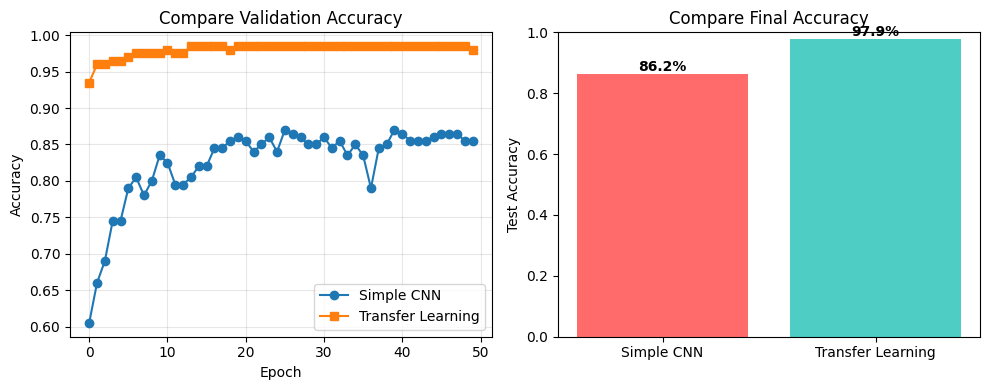

In [7]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(simple_history.history['val_accuracy'], label='Simple CNN', marker='o')
plt.plot(transfer_history.history['val_accuracy'], label='Transfer Learning', marker='s')
plt.title('Compare Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 🔹 2-chi subplot: Yakuniy aniqlik (bar chart)
plt.subplot(1, 2, 2)
categories = ['Simple CNN', 'Transfer Learning']
accuracies = [simple_acc, transfer_acc]
colors = ['#ff6b6b', '#4ecdc4']

bars = plt.bar(categories, accuracies, color=colors)
plt.title('Compare Final Accuracy')
plt.ylabel('Test Accuracy')
plt.ylim([0, 1])

# Har bir ustun ustiga qiymatni yozish
for bar, acc in zip(bars, accuracies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f'{acc:.1%}',
        ha='center',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()